In [1]:
import time
from collections import defaultdict
from utils import plot_model_trajectories
from tqdm import tqdm_notebook
import config

%matplotlib inline

In [2]:
import requests
import matplotlib.pylab as plt
import numpy as np

class ENV1_Proxy:
    def __init__(self, url, key):
        self.url = url
        self.key = key

    def reset(self):
        r = requests.get(url=self.url+'/reset',
                     params = {
                         'user_id':self.key,
                     })
        try:
            return r.json()
        except:
            print(r.content)
            raise

    def predict(self, predicted_score):
        r = requests.get(url=self.url + '/predict',
                     params = {
                         'user_id':self.key,
                         'recommended_item':predicted_score
                     })
        try:
            return r.json()
        except:
            print(r.content)
            raise

In [23]:
import time

class ModelWrapper():
    def __init__(self):
        self.url = 'http://0.0.0.0:5002'
        
        self.train_time = 0
        self.prediction_times = []
        
    def train(self, history):
        
        start = time.time()
        
        r = requests.post(url=self.url+'/train',
                         json = {
                            'nb_users' : history['nb_users'],
                            'nb_items' : history['nb_items'],
                            'user_history' : history['user_history'],
                            'item_history' : history['item_history'],
                            'rating_history' : history['rating_history']
                         })
        
        end = time.time()
        time_spent = end-start
        assert time_spent < 120, 'Train took more than 1 minute : %d s' % time_spent
        self.train_time = time_spent
    
    def predict(self, input_data):
        start = time.time()
        
        r = requests.post(url=self.url+'/predict',
                         json = {
                            'user' : input_data['next_user'],
                            'item' : input_data['next_item'], 
                            'rating' : input_data['rating']
                         })
        
        end = time.time()
        time_spent = end-start
        assert time_spent < 0.1, 'Predict took more than 100ms : %d ms' % time_spent * 1000  
        self.prediction_times.append(time_spent)
        
        return r.json()['rating']
    
    def store_reward(self, reward):
        pass

In [24]:
model = ModelWrapper()

In [25]:
ENV_URL = config.ENV2_URL
KEY = config.KEY

env = ENV1_Proxy(key=KEY, url=ENV_URL)

In [26]:
n_runs = 3
n_steps = 100

results = defaultdict(list)
explicit_feedback_results = defaultdict(lambda: defaultdict(list))

model_name_entry = 'server_' +  time.strftime('%H:%M')

for n in tqdm_notebook(range(n_runs), leave=True, position=0):
    # init model 
    history = env.reset()
    
    model.train(history)
    input_data = {
        'next_user' : history['next_user'],
        'next_item' : history['next_item'],
        'rating'  : None,
    }

    rewards = []
    pred_scores = []
    true_scores = []
    for _ in tqdm_notebook(range(n_steps), desc='run %d' % n, leave=False, position=1):
        time.sleep(0.05)

        prediction = model.predict(input_data)
        res = env.predict(prediction) # get res for prediction

        input_data = res
        
        reward = res['rating']
        rewards.append(reward)
        model.store_reward(reward)
        
        pred_scores.append(prediction)
        true_scores.append(res['rating'])

    explicit_feedback_results[model_name_entry]['predicted'].append(pred_scores)
    explicit_feedback_results[model_name_entry]['true'].append(true_scores)
    results[model_name_entry].append(rewards)

In [19]:
from utils import plot_model_trajectories, plot_model_moving_mse_mae

,Model,Score,Conversion Rate
0,server_16:19,299,1.0


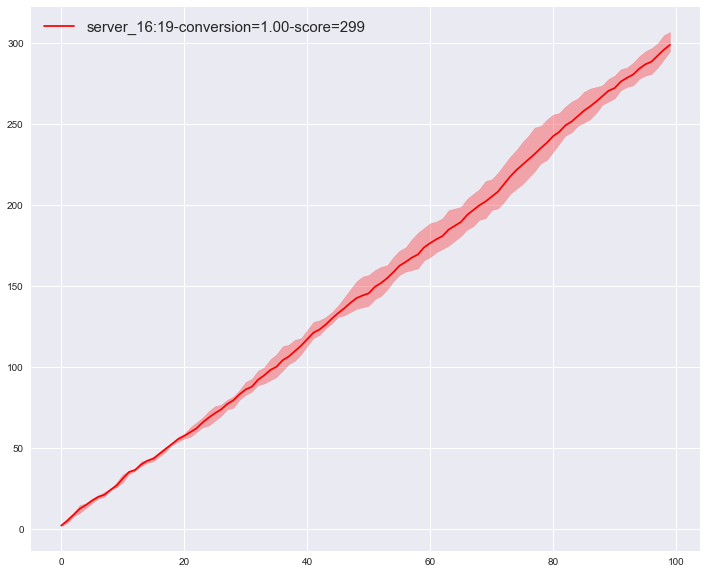

In [22]:
plot_model_trajectories(results)

,Model,mae,mse
0,server_16:19,1.57,3.89


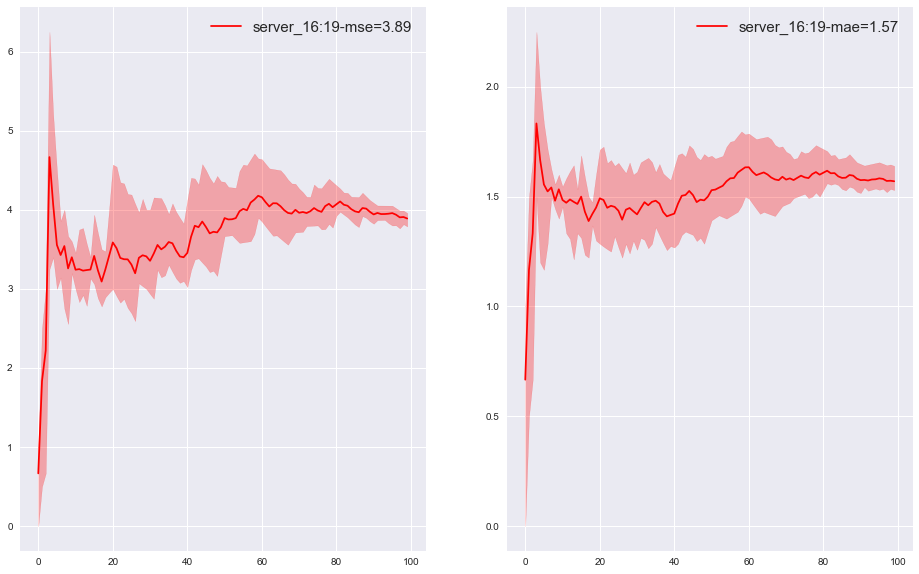

In [21]:
plot_model_moving_mse_mae(implicit_feedback_results)

Train time 0s


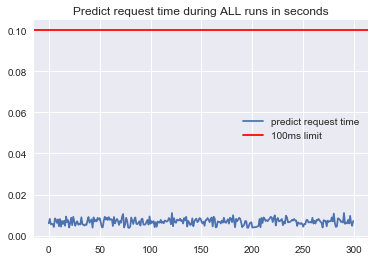

In [35]:
print('Train time %ds' % model.train_time)
plt.plot(model.prediction_times, label='predict request time')
plt.axhline(0.1, color='red', label='100ms limit')
plt.legend()
plt.title('Predict request time during ALL runs in seconds');